# Import Library

In [1]:
from google.colab import userdata

import ast
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Memuat Dataset

In [2]:
# Ambil kredensial dari Google Colab Secrets
kaggle_username = userdata.get('kaggle_username')  # Nama pengguna
kaggle_key = userdata.get('kaggle_key')     # Kunci API

# Set variabel lingkungan untuk Kaggle
os.environ['KAGGLE_USERNAME'] = kaggle_username
os.environ['KAGGLE_KEY'] = kaggle_key

In [3]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
  0% 0.00/25.0M [00:00<?, ?B/s]
100% 25.0M/25.0M [00:00<00:00, 441MB/s]


In [4]:
!unzip anime-recommendations-database.zip

Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


In [5]:
df_anime = pd.read_csv('anime.csv')

In [6]:
df_rating = pd.read_csv('rating.csv')

# Exploratory Data Analysis (EDA)

## Anime Variabel

Menampilkan Isi dan Struktur Dataset Anime

In [7]:
df_anime.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [8]:
df_anime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


<ipython-input-9-8daf4961af9c>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_genres, x='Genre', y='Count', palette='viridis')


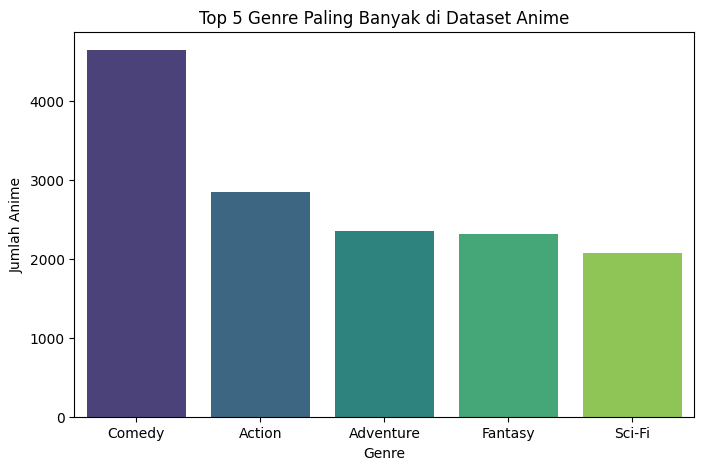

In [9]:
all_genres = df_anime['genre'].dropna().str.split(', ')
flat_genres = [genre for sublist in all_genres for genre in sublist]
genre_counts = Counter(flat_genres)
top5_genres = genre_counts.most_common(5)

df_top_genres = pd.DataFrame(top5_genres, columns=['Genre', 'Count'])

plt.figure(figsize=(8,5))
sns.barplot(data=df_top_genres, x='Genre', y='Count', palette='viridis')
plt.title('Top 5 Genre Paling Banyak di Dataset Anime')
plt.ylabel('Jumlah Anime')
plt.xlabel('Genre')
plt.show()

Insight : Dari output ini, kita dapat melihat seberapa lengkap data dan menilai kualitas dataset anime untuk analisis lebih lanjut seperti pembuatan sistem rekomendasi anime. Kemudian pada visualisasi terdapat genre terbanyak pada dataset ini. Genre Comedy menjadi genre paling banyak.

## Rating Variabel

Menampilkan Isi dan Struktur Dataset Rating

In [10]:
df_rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [11]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


In [12]:
df_rating = df_rating[df_rating.user_id <= 10000]

In [13]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1042697 entries, 0 to 1042696
Data columns (total 3 columns):
 #   Column    Non-Null Count    Dtype
---  ------    --------------    -----
 0   user_id   1042697 non-null  int64
 1   anime_id  1042697 non-null  int64
 2   rating    1042697 non-null  int64
dtypes: int64(3)
memory usage: 31.8 MB


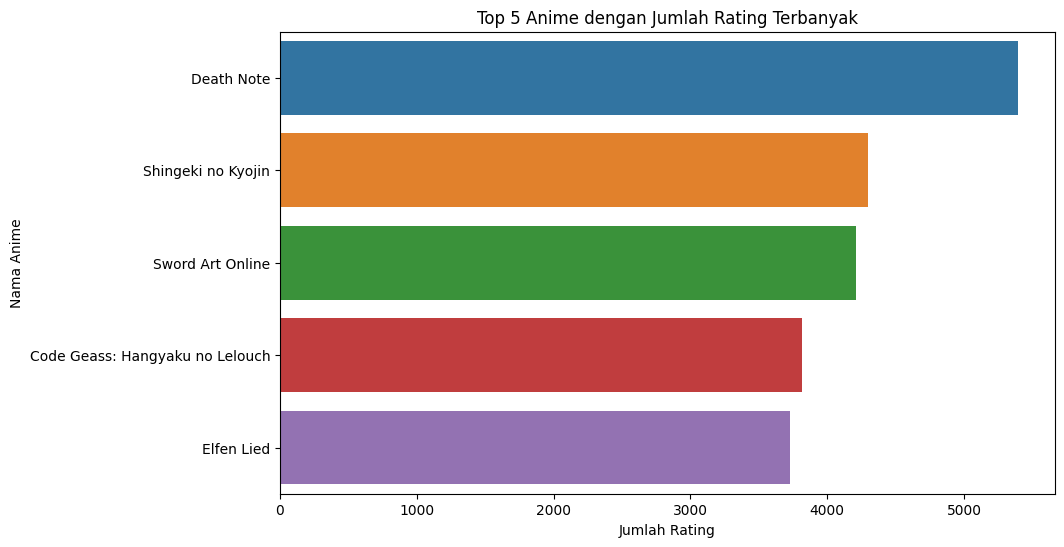

In [14]:
rating_counts = df_rating['anime_id'].value_counts().head(5)

top5_rated_anime = pd.DataFrame({
    'anime_id': rating_counts.index,
    'rating_count': rating_counts.values
}).merge(df_anime[['anime_id', 'name']], on='anime_id')

plt.figure(figsize=(10,6))
sns.barplot(data=top5_rated_anime, x='rating_count', y='name', hue='name', dodge=False, legend=False)
plt.title('Top 5 Anime dengan Jumlah Rating Terbanyak')
plt.xlabel('Jumlah Rating')
plt.ylabel('Nama Anime')
plt.show()

Insight : Dari output ini, kita dapat melihat seberapa lengkap data dan menilai kualitas dataset rating untuk analisis lebih lanjut seperti pembuatan sistem rekomendasi anime. Kode `df_rating = df_rating[df_rating.user_id <= 10000]` digunakan untuk mengambil user_id di bawah 10000. Hal ini agar pada proses rekomendasi tidak terlalu banyak mengambil data. Lalu pada visualisasi Anime `Death Note` menjadi rating terbanyak.

# Data Preparation

## Mengatasi Rating Tidak Valid

Membersihkan nilai rating tidak valid pada dataset rating

In [15]:
df_rating['rating'].unique()

array([-1, 10,  8,  6,  9,  7,  3,  5,  4,  1,  2])

In [16]:
df_rating['rating'] = df_rating['rating'].replace(-1, pd.NA)

Insight :
- `df_rating['rating'].unique()` digunakan untuk mengecek semua nilai unik yang terdapat dalam kolom rating. Ini berguna untuk menemukan adanya nilai tidak valid atau anomali, seperti -1 yang biasanya menandakan bahwa user belum memberi rating sebenarnya (misalnya hanya menonton tapi tidak menilai).

- `df_rating['rating'] = df_rating['rating'].replace(-1, pd.NA)` mengganti semua nilai -1 dengan pd.NA (missing value dalam Pandas). Ini penting agar model rekomendasi tidak menganggap -1 sebagai rating numerik yang valid. Nilai -1 berarti pengguna menonton tetapi tidak menilai anime tersebut.

## Mengatasi Missing Value

Membersihkan nilai kosong pada dataset anime dan rating

In [17]:
df_anime.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


In [18]:
df_anime.dropna(inplace=True)

In [19]:
df_rating.isnull().sum()

,0
user_id,0
anime_id,0
rating,193533


Insight :
- Pada dataset anime, terdapat nilai null pada kolom genre, type, dan rating. Karena tidak jumlah null masih tergolong sedikkit, jadi diputuskan untuk menghapus nilai null tersebut.
- Pada dataset rating, terdapat banyak sekali nilai null pada kolom rating. Hal ini disebabkan pada kode sebelumnya bahwa mengganti nilai anomali (-1) menjadi NaN. Karena -1 adalah pengguna yang menonton tetapi tidak menilai, maka akan dibiarkan saja. Hal ini dibiarkan untuk nanti diproses pada modeling.

## Mengatasi Duplicated Value

Membersihkan nilai duplikat pada dataset anime dan rating

In [20]:
df_anime.duplicated().sum()

np.int64(0)

In [21]:
df_rating.duplicated().sum()

np.int64(0)

Insight : Kode tersebut digunakan untuk mendeteksi apakah ada data duplikat pada kedua dataset, yaitu `df_anime` dan `df_rating`. Fungsi `df_anime.duplicated().sum()` dan `df_rating.duplicated().sum()` menghitung jumlah baris yang terdeteksi sebagai duplikat dalam masing-masing dataframe. Hasil dari kedua perintah tersebut adalah `np.int64(0)`, yang berarti **tidak ada baris duplikat** yang ditemukan dalam kedua dataset. Ini menunjukkan bahwa data yang digunakan sudah bersih dari duplikasi, sehingga tidak perlu dilakukan penghapusan duplikat. Hal ini penting karena data duplikat dapat menyebabkan bias dalam perhitungan rekomendasi, terutama jika rating yang sama dihitung lebih dari sekali.


# Model Development

## Content Based Filtering



### Tfidf Vectorizer

Meng-ekstraksi fitur genre menggunakan TfidfVectorizer

In [22]:
vec = TfidfVectorizer(stop_words='english', tokenizer=lambda x: x.split(', '))
genre_matrix = vec.fit_transform(df_anime["genre"])

/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Insight:
Kode tersebut menggunakan `TfidfVectorizer` untuk mengubah data genre anime menjadi representasi numerik berbobot berdasarkan frekuensi relatif setiap genre. Dengan `tokenizer=lambda x: x.split(', ')`, genre dipisah per kata kunci (misalnya "Action", "Comedy"), sehingga genre yang lebih unik mendapat bobot lebih tinggi. Hasilnya adalah matriks TF-IDF (`genre_matrix`) yang dapat digunakan untuk menghitung kesamaan antar anime, misalnya dalam sistem rekomendasi.


### Cosine Similarity

Menghitung kemiripan antara anime berdasarkan genre dengan Cosine Similarity

In [23]:
anime_similarity = cosine_similarity(genre_matrix, genre_matrix)
anime_similarity

array([[1.        , 0.14692967, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14692967, 1.        , 0.188587  , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.188587  , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

Insight:
`cosine_similarity(genre_matrix, genre_matrix)` menghitung tingkat kemiripan antar anime berdasarkan vektor TF-IDF genre mereka. Nilai pada `anime_similarity` berkisar antara 0 hingga 1, di mana angka yang lebih tinggi menunjukkan kemiripan genre yang lebih besar. Matriks ini berguna dalam sistem content-based filtering untuk merekomendasikan anime dengan genre serupa, meskipun user belum banyak memberikan rating, karena cukup mengandalkan informasi konten.


### Mendapatkan Rekomendasi

Rekomendasi anime berdasarkan genre yang mirip

In [24]:
def recommend(title, cosine_sim=anime_similarity):
    idx = df_anime[df_anime['name'] == title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)[1:6]
    anime_indices = [i[0] for i in sim_scores]
    return df_anime['name'].iloc[anime_indices]

In [25]:
recommend("Naruto")

,name
615,Naruto: Shippuuden
841,Naruto
1103,Boruto: Naruto the Movie - Naruto ga Hokage ni...
1343,Naruto x UT
1472,Naruto: Shippuuden Movie 4 - The Lost Tower


Insight:
Fungsi `recommend()` menghasilkan 5 anime dengan genre paling mirip terhadap judul yang diberikan, berdasarkan nilai tertinggi dari cosine similarity. Ini merupakan penerapan sederhana content-based filtering yang memanfaatkan kemiripan konten (genre) untuk memberikan rekomendasi yang relevan.


# Metrik Evaluasi

Untuk mengevaluasi kinerja model rekomendasi berbasis konten, digunakan metrik Precision@K.

In [26]:
def precision_at_k(title, k=5):
    try:
        recommended = recommend(title, anime_similarity).tolist()
        original_genres = set(df_anime[df_anime['name'] == title]['genre'].values[0].split(', '))

        relevant = 0
        for rec in recommended[:k]:
            rec_genres = set(df_anime[df_anime['name'] == rec]['genre'].values[0].split(', '))
            if len(original_genres.intersection(rec_genres)) > 0:
                relevant += 1

        return relevant / k
    except IndexError:
        return f"Anime dengan nama '{title}' tidak ditemukan."

In [27]:
print(precision_at_k("Naruto"))

1.0


Insight:
Precision\@K pada sistem rekomendasi anime mengukur seberapa relevan rekomendasi yang diberikan berdasarkan kemiripan genre dengan anime asal. Dalam kasus ini, nilai precision sebesar 1.0 untuk anime *Naruto* menunjukkan bahwa semua rekomendasi yang diberikan memiliki kesamaan genre dengan *Naruto*, menandakan bahwa sistem mampu menyarankan anime yang sesuai secara tematik. Meskipun ini merupakan indikasi positif terhadap akurasi sistem, evaluasi berbasis genre saja belum sepenuhnya mencerminkan relevansi menyeluruh dari sisi cerita, kualitas, atau preferensi pengguna secara individual.
